# Прогнозирование температуры звезды

## Описание задачи

- Заказчик, обсерватория «Небо на ладони»
- Придумать, как с помощью нейросети определять абсолютную температуру на поверхности обнаруженных звёзд. Улучшить точность предсказания температуры звёзд машинным обучением вместо других методов
- Обычно использовались следующие методы (каждый из них имеет плюсы и минусы)
    - Закон смещения Вина
    - Закон Стефана-Больцмана
    - Спектральный анализ
- В базе обсерватории есть характеристики уже изученных 240 звёзд
- Метрика RMSE должна быть менее 4500
- Сделать Baseline и улушченную версию нейронной сети у которой оставить: количество слоёв, нейронов, вид функции активации — оставьте как в Baseline, чтобы сравнить результат

## Описание данных

- Обучающие признаки
    - `Luminosity(L/Lo)` — относительная светимость, светимость звезды относительно Солнца
    - `Radius(R/Ro)` — относительный радиус, радиус звезды относительно радиуса Солнца
    - `Absolute magnitude(Mv)` — абсолютная звёздная величина, физическая величина, характеризующая блеск звезды
    - `Star color` — звёздный цвет (`white`, `red`, `blue`, `yellow`, `yellow-orange` и др.), цвет звезды, который определяют на основе спектрального анализа
    - `Star type` — Тип звезды
        | Тип звезды | Номер, соответствующий типу |
        | --- | --- |
        | Коричневый карлик | 0 |
        | Красный карлик | 1 |
        | Белый карлик | 2 |
        | Звёзды главной последовательности | 3 |
        | Сверхгигант | 4 |
        | Гипергигант | 5 |

- Целевой признак
    - `Temperature T(K)` — абсолютная температура, температура на поверхности звезды в Кельвинах.


- Светимость Солнца (англ. *Average Luminosity of Sun*) — $L_0 = 3.828 \cdot 10^{26}\,Вт$
- Радиус Солнца (англ. *Average Radius of Sun*) — $R_0 = 6.9551\cdot 10^8\,м$

## Задача в терминах машинного обучения

- Регрессия
- Полносвязная нейронная сеть прямого распространения
- Метрика RMSE менее 4500

## Подключение библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import copy
import math
import random
import itertools

from math import ceil
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from IPython.display import display, Markdown

In [2]:
RANDOM_STATE = 12345
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [3]:
def rmse(prediction, target):
    return ((prediction - target) ** 2).mean() ** 0.5

## Загрузка данных

In [4]:
df = pd.read_csv('/datasets/6_class.csv', index_col=0)
cdf = df.copy() # clear dataframe

## Изучение данных

In [5]:
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


## Предобработка данных

In [7]:
cdf.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

Переименуем столбцы для единства стиля и простоты доступа

In [8]:
cdf.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']

In [9]:
cdf.star_type.unique()

array([0, 1, 2, 3, 4, 5])

In [10]:
cdf.star_color.unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

В колонке цвета есть неявные дубликаты, исправим их

In [11]:
cdf.star_color = cdf.star_color.str.lower().str.replace('-', ' ').str.strip()

In [12]:
cdf.star_color.unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'white yellow', 'yellowish', 'orange red'], dtype=object)

После попыток обучения нейросети, обнаружилось что данные могут быть не в порядке в этих обозначениях цветов, они не соответствуют принятым [Stellar classification — Harvard spectral classification](https://en.wikipedia.org/wiki/Stellar_classification#Harvard_spectral_classification)

In [13]:
def set_star_color(t):
    if 30_000 <= t:
        return 'blue'
    elif 10_000 <= t < 30_000:
        return 'blue white'
    elif 7_500 <= t < 10_000:
        return 'white'
    elif 6_000 <= t < 7_500:
        return 'yellow white'
    elif 5_200 <= t < 6_000:
        return 'yellow'
    elif 3_700 <= t < 5_200:
        return 'light orange'
    else:
        return 'orange red'

In [14]:
cdf.star_color = cdf.temperature.apply(set_star_color)

In [15]:
cdf.star_color.unique()

array(['orange red', 'blue white', 'white', 'yellow white', 'blue',
       'yellow', 'light orange'], dtype=object)

Проверка на пропуски

In [16]:
cdf.isna().sum().to_frame()

,0
temperature,0
luminosity,0
radius,0
absolute_magnitude,0
star_type,0
star_color,0


Проверка на явные дубликаты

In [17]:
df.duplicated().sum()

0

## Анализ данных

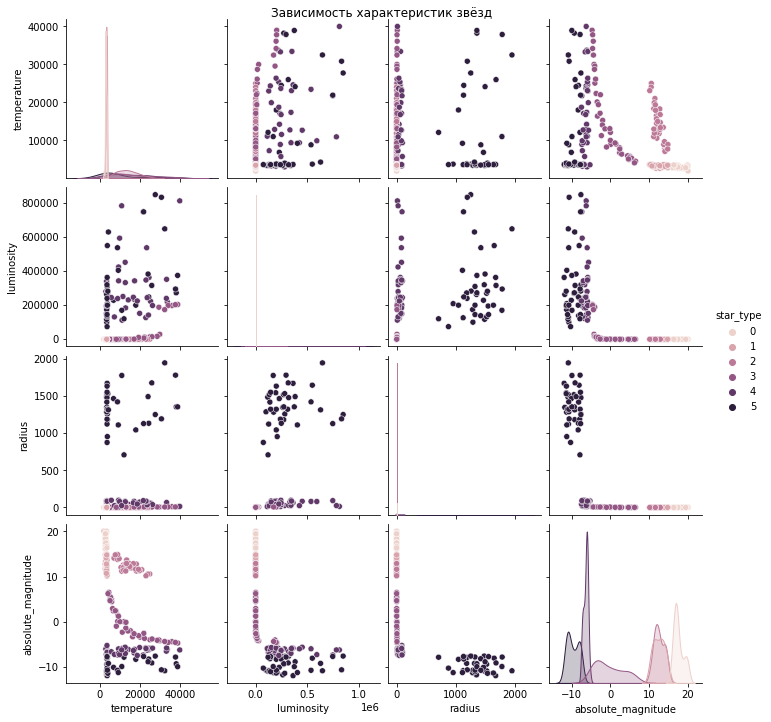

In [18]:
sns.pairplot(cdf, hue='star_type').fig.suptitle('Зависимость характеристик звёзд', y=1);

- при уменьшении температуры увеличивается абсолютная звёздная величина
- выделяются кластеры по температуре и абсолютной звёздной величине

In [19]:
cdf.describe()

,temperature,luminosity,radius,absolute_magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


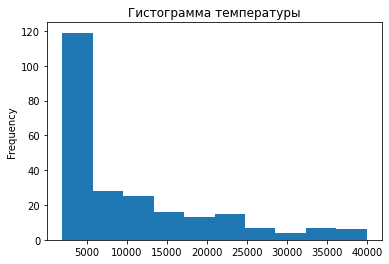

In [20]:
cdf.temperature.plot(kind='hist').set_title('Гистограмма температуры');

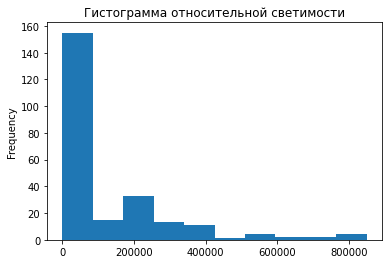

In [21]:
cdf.luminosity.plot(kind='hist').set_title('Гистограмма относительной светимости');

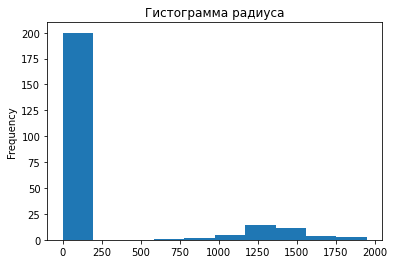

In [22]:
cdf.radius.plot(kind='hist').set_title('Гистограмма радиуса');

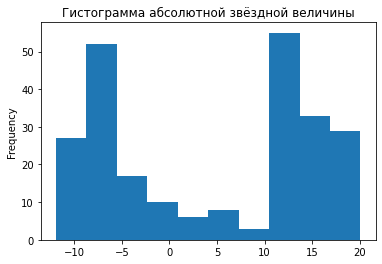

In [23]:
cdf.absolute_magnitude.plot(kind='hist').set_title('Гистограмма абсолютной звёздной величины');

### Вывод

- В датасете всго лишь 240 наблюдений
- Температура звёзд находится в диапазоне от 1939 до 40000 по Кельвину, медиана 5776 градусов
- Светимость звезды относительно Солнца от 0.00008 до 849420, медиана 0.0705
- Радиус относительно Солнца от 0.0084 до 1948.5, медиана 0.7625
- Абсолютная звёздная величина от -11.92 до 20.06, где чаще всего встречаются значения -7 и 13, а меньше всего 8
- Количество звёзд каждого типа по 40, всего 6 типов

## Предобработка признаков

In [24]:
categorial_columns = ['star_type', 'star_color']
numerical_columns = ['luminosity', 'radius', 'absolute_magnitude']

X_train, X_test, y_train, y_test = train_test_split(
    cdf.drop(['temperature'], axis=1), 
    cdf.temperature, 
    test_size=0.3, 
    shuffle=True,
    random_state=RANDOM_STATE
)

In [25]:
cdf.columns

Index(['temperature', 'luminosity', 'radius', 'absolute_magnitude',
       'star_type', 'star_color'],
      dtype='object')

In [26]:
cdf.head()

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,orange red
1,3042,0.000500,0.1542,16.60,0,orange red
2,2600,0.000300,0.1020,18.70,0,orange red
3,2800,0.000200,0.1600,16.65,0,orange red
4,1939,0.000138,0.1030,20.06,0,orange red


### One-Hot Encoding

In [27]:
# Применяем технику One-Hot Encoding
# с удалением избыточных признаков
ohe = OneHotEncoder(drop='first')

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[categorial_columns]).toarray(), columns=ohe.get_feature_names())
X_test_ohe = pd.DataFrame(ohe.transform(X_test[categorial_columns]).toarray(), columns=ohe.get_feature_names())

X_train_ohe.shape, X_test_ohe.shape

((168, 11), (72, 11))

### Standart Scaling

In [28]:
sc = StandardScaler()

X_train_sc = pd.DataFrame(sc.fit_transform(X_train[numerical_columns]), columns=numerical_columns)
X_test_sc = pd.DataFrame(sc.transform(X_test[numerical_columns]), columns=numerical_columns)

X_train_sc.shape, X_test_sc.shape

((168, 3), (72, 3))

### Объединение

In [29]:
X_train_ohe_sc_t = torch.FloatTensor(pd.concat([X_train_sc, X_train_ohe], axis=1).values)
y_train_t = torch.FloatTensor(y_train.values)

X_test_ohe_sc_t = torch.FloatTensor(pd.concat([X_test_sc, X_test_ohe], axis=1).values)
y_test_t = torch.FloatTensor(y_test.values)

### Проверка

In [30]:
pd.concat([X_train_sc, X_train_ohe], axis=1)

,luminosity,radius,absolute_magnitude,x0_1,x0_2,x0_3,x0_4,x0_5,x1_blue white,x1_light orange,x1_orange red,x1_white,x1_yellow,x1_yellow white
0,0.160953,-0.382081,-1.148865,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.736599,1.912754,-1.527235,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.592531,-0.432492,1.105313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.592531,-0.432680,0.851494,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.007278,-0.257637,-0.997895,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.782147,-0.358880,-1.160188,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
164,-0.592531,-0.432522,1.239299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
165,-0.592531,-0.432675,0.860929,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
166,3.714928,-0.238654,-1.160754,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Общие функции для создания нейросети

In [31]:
def plot_predict(
    net: torch.nn.modules.container.Sequential,
    x_search: torch.Tensor,
    true: torch.Tensor,
    title: str
):
    """Отрисовка графика реальных значений и предсказаний"""
    y_predict = net.forward(x_search)
    x = range(len(true))
    y1 = true.numpy()
    y2 = y_predict.flatten().detach().numpy()
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.plot(x, y1, label='Факт')
    plt.plot(x, y2, label='Предсказание')
    plt.legend(loc='upper right')
    plt.show();

In [32]:
def neuronet(X_train, y_train, learning_rate, num_epochs, batch_size, net_layers, init_weights_func, out=True):
    """
    learning_rate — скорость обучения
    слишком большая — можно проскочить минимум
    слишком маленькая — алгоритм будет работать очень медленно

    num_epochs — количество эпох обучения
    
    batch_size — размер батча
    
    net_layers — архитектура нейросети
    
    init_weights_func — функция предварительной инициализации нейросети
    """
    
    # Разделение на выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, 
        y_train, 
        test_size=0.3, 
        shuffle=True,
        random_state=RANDOM_STATE
    )
    
    # Преобразование в тензор
    X_train_t = torch.FloatTensor(X_train)
    X_valid_t = torch.FloatTensor(X_valid)

    y_train_t = torch.FloatTensor(y_train.values)
    y_valid_t = torch.FloatTensor(y_valid.values)
    
    # Конструирование архитектуры
    net = nn.Sequential(*net_layers)
    
    # Для сохранения модели после каждой эпохи
    estimators = []

    # предварительная инициализация весов для ускорения и улучшения обучения
    net.apply(init_weights_func)

    # функция потерь
    loss = nn.MSELoss()

    # Оптимизатор ищет минимум для функции потерь
    # Adaptive Moment Estimation, Adam
#     optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adamax(net.parameters(), lr=learning_rate)

    if out: plot_predict(net, X_train_t, y_train_t, "Предсказания сети при начальной инициализации")
    
    # Обучение нейросети
    num_batches = ceil(len(X_train_t) / batch_size)
    
    
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train_t))
        
        for batch_index in range(num_batches):
            # PyTorch обладает свойством накапливать градиент, что может навредить обучению
            # по этому перед каждым шагом нужно обнулять градиент
            optimizer.zero_grad()
            
            start_index = batch_index * batch_size
            batch_indexes = order[start_index:start_index + batch_size]
            
            X_batch = X_train_t[batch_indexes]
            y_batch = y_train_t[batch_indexes]

            # Вычисляем предсказания на текущем шаге
            y_hat = net.forward(X_batch).flatten()

            # Вычисляем функцию потерь
            loss_value = loss(y_hat, y_batch)
            # Вычисляем значение градиента функции потерь
            loss_value.backward()

            # выполняется шаг работы оптимизатора (обновление весов в сети)
            optimizer.step()

        if epoch % (num_epochs/10) == 0:
            # Перевод режима сети с обучения на предсказание, что бы учитывать
            # например батчи
            net.eval()
            
            valid_predict = net.forward(X_valid_t)
            metric = rmse(valid_predict, y_valid_t.reshape(-1, 1))
            if out: print(metric.item())

            # Сохраняем сеть на разных эпохах, что бы выбрать ту где
            # ещё не началось переобучение — выбираем лучшую модель
            estimators.append([metric, copy.deepcopy(net)])
        
    if out: plot_predict(net, X_train_t, y_train_t, "Предсказания сети после обучения")
    
    return estimators

## Построение базовой нейронной сети

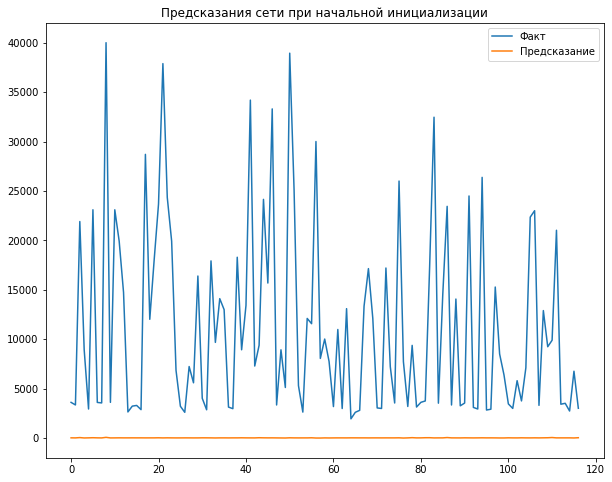

10476.326171875
3380.71337890625
3486.42333984375
3630.9033203125
3581.708984375
3685.64501953125
3718.072021484375
3809.547607421875
3901.27392578125
3918.651611328125


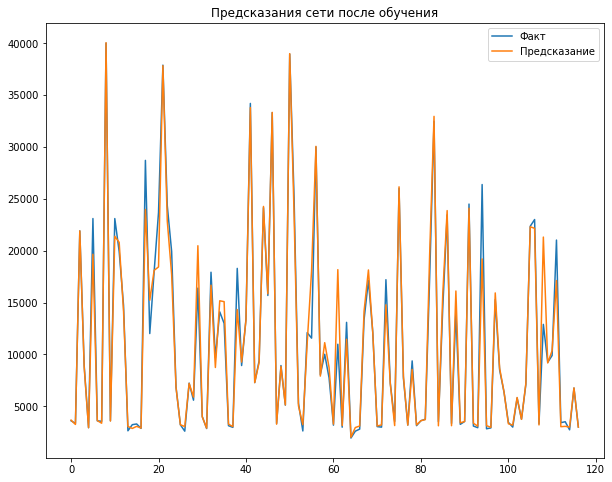

In [36]:
def init_weights_base(layer):
    # выбирает параметры распределений для инициализации
    # это зависит от того, насколько функция активации сети симметрична относительно 0
    if type(layer) == nn.Linear: # Проверка, что слой — полносвязный
        nn.init.normal_(layer.weight, mean=0, std=1)
        nn.init.normal_(layer.bias, mean=0, std=1)

num_neurons_per_layer_base = [14, 29, 6, 1]
net_layers_base = []

for i in range(1, len(num_neurons_per_layer_base) - 1):
    net_layers_base.append(nn.Linear(num_neurons_per_layer_base[i-1], num_neurons_per_layer_base[i]))
    net_layers_base.append(nn.ReLU())
net_layers_base.append(nn.Linear(num_neurons_per_layer_base[-2], num_neurons_per_layer_base[-1]))

estimators_base = neuronet(
    X_train = X_train_ohe_sc_t,
    y_train = y_train,
    learning_rate = 0.01,
    num_epochs = 10000,
    batch_size = 6,
    net_layers=net_layers_base,
    init_weights_func=init_weights_base,
)

Тестовая выборка

In [37]:
test_predict = min(estimators_base)[1].forward(X_test_ohe_sc_t)
metric = rmse(test_predict, y_test_t.reshape(-1, 1))
print(metric.item())

3826.451904296875


### Вывод

- Функция оптимизации `Adamax` лучше чем `Adam`
- Изменение предварительной инициализации весов под имеющееся распределение не всегда способствует лучшему обучению
- Под конкретную задачу не удалось получить хорошее предсказание используя только 1 скрытый слой
- Для задачи регрессии в последнем слое лучше использовать не функцию активации, а линейную
- Иногда при одних и тех же плохих гиперпараметрах сеть перестаёт хорошо обучаться, может выдать хорошую метрику, а затем плохую, т.е. плохая стабильность модели
- В целом нужно много экспериментов и опыт для успешного подбора гиперпарметров: архитектура_сети, скорость обучения, количество эпох, размер батча, предварительная инициализация
- Лучшая метрика на валидационной выборке была **RMSE 6371.9111**
- Метрика на тестовой выборке **12146.8710**

## Улучшение нейронной сети

In [40]:
grid_params = {
    'learning_rate': [1, 0.1, 0.01, 0.001],
    'num_epochs': [1000, 300, 200],
    'dropout': [True, False],
    'batch_norm': [True, False]
}

def grid_search(grid_params):
    results = []
    
    # Генерируем все возможные сочетания параметров
    # все возможные эксперименты из заданного набора
    keys, values = zip(*grid_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for exp in experiments:
        print(exp)
        def init_weights(layer):
            pass # без предварительной инициализации

        num_neurons_per_layer = [14, 29, 6, 1]
        net_layers = []

        for i in range(1, len(num_neurons_per_layer) - 1):
            net_layers.append(nn.Linear(num_neurons_per_layer[i-1], num_neurons_per_layer[i]))
            if exp['batch_norm']:
                net_layers.append(nn.BatchNorm1d(num_neurons_per_layer[i]))
            net_layers.append(nn.ReLU())
            if exp['dropout']:
                if i in (1,2):
                    net_layers.append(nn.Dropout(0.2))
        net_layers.append(nn.Linear(num_neurons_per_layer[-2], num_neurons_per_layer[-1]))

        estimators = neuronet(
            X_train = X_train_ohe_sc_t,
            y_train = y_train,
            learning_rate = exp['learning_rate'],
            num_epochs = exp['num_epochs'],
            batch_size = 6,
            net_layers=net_layers,
            init_weights_func=init_weights,
            out=False
        )
        
        # Выбираем лучшую модель в рамках одного эксперимента
        best_model = min(estimators)
        exp['best_metric'] = best_model[0] #.item()
        exp['best_model'] = best_model[1]
        results.append(exp)
    return results

results = grid_search(grid_params)

pd.DataFrame(results)

{'learning_rate': 1, 'num_epochs': 1000, 'dropout': True, 'batch_norm': True}
{'learning_rate': 1, 'num_epochs': 1000, 'dropout': True, 'batch_norm': False}
{'learning_rate': 1, 'num_epochs': 1000, 'dropout': False, 'batch_norm': True}
{'learning_rate': 1, 'num_epochs': 1000, 'dropout': False, 'batch_norm': False}
{'learning_rate': 1, 'num_epochs': 300, 'dropout': True, 'batch_norm': True}
{'learning_rate': 1, 'num_epochs': 300, 'dropout': True, 'batch_norm': False}
{'learning_rate': 1, 'num_epochs': 300, 'dropout': False, 'batch_norm': True}
{'learning_rate': 1, 'num_epochs': 300, 'dropout': False, 'batch_norm': False}
{'learning_rate': 1, 'num_epochs': 200, 'dropout': True, 'batch_norm': True}
{'learning_rate': 1, 'num_epochs': 200, 'dropout': True, 'batch_norm': False}
{'learning_rate': 1, 'num_epochs': 200, 'dropout': False, 'batch_norm': True}
{'learning_rate': 1, 'num_epochs': 200, 'dropout': False, 'batch_norm': False}
{'learning_rate': 0.1, 'num_epochs': 1000, 'dropout': True, 

,learning_rate,num_epochs,dropout,batch_norm,best_metric,best_model
0,1.000,1000,True,True,"tensor(3089.6123, grad_fn=<PowBackward0>)","[Linear(in_features=14, out_features=29, bias=..."
1,1.000,1000,True,False,"tensor(3208.3040, grad_fn=<PowBackward0>)","[Linear(in_features=14, out_features=29, bias=..."
2,1.000,1000,False,True,"tensor(3046.7542, grad_fn=<PowBackward0>)","[Linear(in_features=14, out_features=29, bias=..."
3,1.000,1000,False,False,"tensor(3030.8787, grad_fn=<PowBackward0>)","[Linear(in_features=14, out_features=29, bias=..."
4,1.000,300,True,True,"tensor(3009.4690, grad_fn=<PowBackward0>)","[Linear(in_features=14, out_features=29, bias=..."
5,1.000,300,True,False,"tensor(2784.6836, grad_fn=<PowBackward0>)","[Linear(in_features=14, out_features=29, bias=..."
6,1.000,300,False,True,"tensor(2596.6089, grad_fn=<PowBackward0>)","[Linear(in_features=14, out_features=29, bias=..."
7,1.000,300,False,False,"tensor(3003.3013, grad_fn=<PowBackward0>)","[Linear(in_features=14, out_features=29, bias=..."
8,1.000,200,True,True,"tensor(2919.3232, grad_fn=<PowBackward0>)","[Linear(in_features=14, out_features=29, bias=..."
9,1.000,200,True,False,"tensor(2823.4624, grad_fn=<PowBackward0>)","[Linear(in_features=14, out_features=29, bias=..."


Лучшая модель по результатам перебора параметров

In [52]:
t = pd.DataFrame(results)
t.best_metric = t.best_metric.apply(lambda x: x.item())
t[t.best_metric == t.best_metric.min()]

,learning_rate,num_epochs,dropout,batch_norm,best_metric,best_model
18,0.1,300,False,True,2540.112549,"[Linear(in_features=14, out_features=29, bias=..."


На тестовой выборке

In [51]:
test_predict = results[18]['best_model'].forward(X_test_ohe_sc_t)
metric = rmse(test_predict, y_test_t.reshape(-1, 1))
print(metric.item())

4230.94287109375


In [54]:
t.pivot_table(columns='dropout', values='best_metric', aggfunc='mean')

dropout,False,True
best_metric,4274.177643,4557.303569


In [55]:
t.pivot_table(columns='batch_norm', values='best_metric', aggfunc='mean')

batch_norm,False,True
best_metric,4998.317596,3833.163615


In [57]:
4557-4274

283

### Вывод

- На экспериментах по улучшению модели было сделано предположение, что есть проблема в данных по тому что все возможные технихи были применены, но метрика оставалась низкой. Проблема оказалась в признаке цвета звёзд
- Сильно улучшила метрику замена функции активации с `Tanh` на `ReLU`
- Хорошего эффекта Batch Normalization не видно, если плохая функция активации
- Модель работает чуть хуже лучше с Dropout в среднем с разницей 283 RMSE
- Модель работает значительно лучше с Batch Normalization в среднем с разницей 1165 RMSE
- Лучшей модели при переборе удалось достичь при **RMSE 2540** на валидационной выборке и таких параметрах
    - `learning_rate = 0.1`
    - `num_epochs = 300`
    - `dropout = False`
    - `batch_norm = True`
- Метрика на тестовой выборке **RMSE 4230**

## Выводы

**Анализ данных**

- В датасете всго лишь 240 наблюдений
- Температура звёзд находится в диапазоне от 1939 до 40000 по Кельвину, медиана 5776 градусов
- Светимость звезды относительно Солнца от 0.00008 до 849420, медиана 0.0705
- Радиус относительно Солнца от 0.0084 до 1948.5, медиана 0.7625
- Абсолютная звёздная величина от -11.92 до 20.06, где чаще всего встречаются значения -7 и 13, а меньше всего 8
- Количество звёзд каждого типа по 40, всего 6 типов

**Результаты базовой модели**

- Функция оптимизации `Adamax` лучше чем `Adam`
- Изменение предварительной инициализации весов под имеющееся распределение не всегда способствует лучшему обучению
- Под конкретную задачу не удалось получить хорошее предсказание используя только 1 скрытый слой
- Для задачи регрессии в последнем слое лучше использовать не функцию активации, а линейную
- Иногда при одних и тех же плохих гиперпараметрах сеть перестаёт хорошо обучаться, может выдать хорошую метрику, а затем плохую, т.е. плохая стабильность модели
- В целом нужно много экспериментов и опыт для успешного подбора гиперпарметров: архитектура_сети, скорость обучения, количество эпох, размер батча, предварительная инициализация
- Лучшая метрика на валидационной выборке была **RMSE 6371.9111**
- Метрика на тестовой выборке **12146.8710**

**Результаты улучшенной модели**

- На экспериментах по улучшению модели было сделано предположение, что есть проблема в данных по тому что все возможные технихи были применены, но метрика оставалась низкой. Проблема оказалась в признаке цвета звёзд
- Сильно улучшила метрику замена функции активации с `Tanh` на `ReLU`
- Хорошего эффекта Batch Normalization не видно, если плохая функция активации
- Модель работает чуть хуже лучше с Dropout в среднем с разницей 283 RMSE
- Модель работает значительно лучше с Batch Normalization в среднем с разницей 1165 RMSE
- Лучшей модели при переборе удалось достичь при **RMSE 2540** на валидационной выборке и таких параметрах
    - `learning_rate = 0.1`
    - `num_epochs = 300`
    - `dropout = False`
    - `batch_norm = True`
- Метрика на тестовой выборке **RMSE 4230**

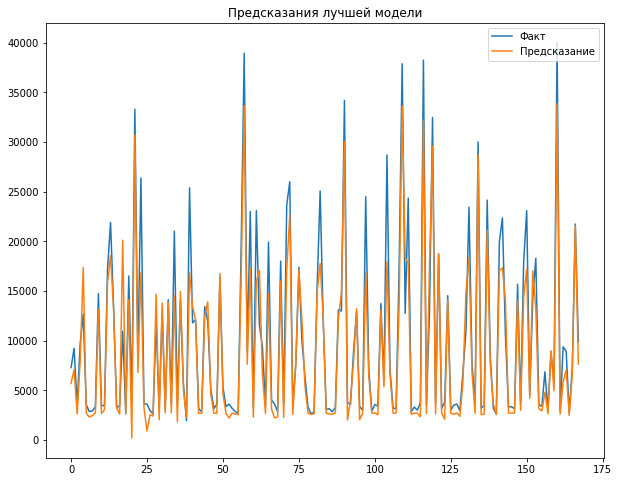

In [58]:
plot_predict(results[18]['best_model'], X_train_ohe_sc_t, y_train_t, "Предсказания лучшей модели")